In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import os
from io import open
import glob
import string
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from scipy import spatial
from sklearn.manifold import TSNE

from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

# import data_utils.py

#import sys
#sys.path.append(os.path.join('.', '..','...'))

#from google.colab import files
#uploaded = files.upload()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Load and prepare data

In [0]:
path = os.getcwd()
train_file = os.path.join(path, 'gdrive/My Drive/Colab Notebooks/Project DL/awd_lstm_lm_master/data/penn/train.txt')
validation_file = os.path.join(path, 'gdrive/My Drive/Colab Notebooks/Project DL/awd_lstm_lm_master/data/penn/valid.txt')
test_file = os.path.join(path, 'gdrive/My Drive/Colab Notebooks/Project DL/awd_lstm_lm_master/data/penn/test.txt')

In [0]:
#def data_split(train_file):
with open(train_file, 'r') as f:
    traintext = f.read()
traintext = traintext.split()

with open(validation_file, 'r') as f:
    validationtext = f.read()
validationtext = validationtext.split()

with open(test_file, 'r') as f:
    testtext = f.read()
testtext = testtext.split()

train_set = traintext
val_set = validationtext
test_set = testtext

In [4]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

887521
70390
78669


#Define hyperparameters

In [0]:
seq_size=16
batch_size=40
embedding_size= 512
lstm_size= 512
n_layers = 2
top_k = 5
epochs = 60
lr = 0.0001
dropout = 0
WeightDecay = 0.4

# Make dictionary, batches, and indexing for training

In [0]:
def get_data_from_file(dataset, batch_size, seq_size):
    
    word_counts = Counter(dataset)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in dataset]
    n_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:n_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text

In [7]:
int_to_vocab, vocab_to_int, n_vocab, train_in_text, train_out_text = get_data_from_file(
    train_set, batch_size, seq_size)

Vocabulary size 9999


#Make batches and indexing for validation

In [0]:
val_int_text = [vocab_to_int[w] for w in val_set]

var1 = len(val_int_text) % batch_size                                   #snake
val_in_text = val_int_text[:] if var1==0 else  val_int_text[:-var1]   #snake

#n_val_batches = int(len(val_int_text) / (seq_size * batch_size))
#val_in_text = val_int_text[:n_val_batches * batch_size * seq_size]

val_out_text = np.zeros_like(val_in_text)
val_out_text[:-1] = val_in_text[1:]
val_out_text[-1] = val_in_text[0]
val_in_text = np.reshape(val_in_text, (batch_size, -1))
val_out_text = np.reshape(val_out_text, (batch_size, -1))

# Make batches and indexing for test

In [0]:
test_int_text = [vocab_to_int[w] for w in test_set]

var2 = len(test_int_text) % batch_size                                   #snake
test_in_text = test_int_text[:] if var2==0 else  test_int_text[:-var2]   #snake

#n_test_batches = int(len(test_int_text) / (seq_size * batch_size))
#test_in_text2 = test_int_text[:n_test_batches * batch_size * seq_size]

test_out_text = np.zeros_like(test_in_text)
test_out_text[:-1] = test_in_text[1:]
test_out_text[-1] = test_in_text[0]
test_in_text = np.reshape(test_in_text, (batch_size, -1))
test_out_text = np.reshape(test_out_text, (batch_size, -1))

print(test_in_text.shape)
print(len(test_int_text))
print(len(test_in_text1))
print(len(test_in_text2))
print(var2)

In [0]:
def get_batches(in_text, out_text, batch_size, seq_size):
    n_batches = np.prod(in_text.shape) // (seq_size*batch_size)
    for i in range(0, n_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

#Define the model

In [0]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        
        self.lstm = nn.LSTM(input_size = embedding_size,
                            hidden_size = lstm_size,
                            num_layers = n_layers,
                            batch_first = True, dropout = dropout)

        self.dense = nn.Linear(lstm_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)
        
        return logits, state
    
    def zero_state(self, batch_size):

      return (torch.zeros(n_layers, batch_size, self.lstm_size),
            torch.zeros(n_layers, batch_size, self.lstm_size))

In [0]:
def get_loss_and_train_op(net, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=(0.9,0.999), eps=1e-08, weight_decay = WeightDecay, amsgrad=False)
    return criterion, optimizer

In [0]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
torch.cuda.is_available()

True

In [0]:
def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k):
    net.eval()

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)

    for w in words:
        ix = torch.LongTensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])
    
    for _ in range(100):
        ix = torch.LongTensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))

In [0]:
net = RNNModule(n_vocab, seq_size, embedding_size, lstm_size)#, n_layers)

net = net.to(device)

criterion, optimizer = get_loss_and_train_op(net, lr)

In [0]:
training_loss = []
validation_loss = []
testing_loss = []

Time: 0m 18s Epoch: 1/60

Training loss: 6.19405460357666 	 Validation loss: 6.0918169021606445 	 Perplexity: 442.22415969859475
donald trump the N billion of N to <unk> a N billion of N N to the company and a N of N billion N in N N N to $ N to $ N a <unk> of $ $ N to $ the N of $ billion a year and a year and $ $ $ $ a <unk> and <unk> and N million in $ billion million in N N of a year in $ billion the company said the u.s. 's N to the N billion in $ $ a $ the year the N million of N to the


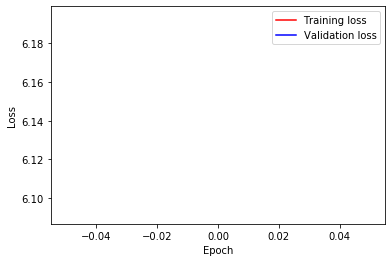

Time: 0m 37s Epoch: 2/60

Training loss: 5.853724002838135 	 Validation loss: 5.820716381072998 	 Perplexity: 337.21354051941194
donald trump u.s. <unk> the market is a <unk> in a $ years a share for the N years a share of <unk> <unk> of its <unk> and a <unk> in a year <unk> of N N in N N to the u.s. 's <unk> <unk> in a N billion N billion of <unk> 's N years the u.s. market and a year and the <unk> <unk> the <unk> of the company 's new market in N the market and N <unk> in its stock and N the market 's company said that <unk> a N <unk> and <unk> in a N million


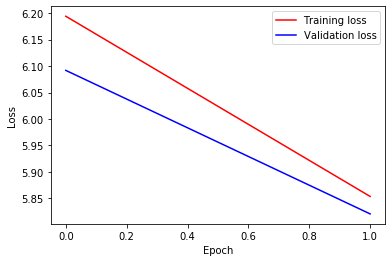

Time: 0m 56s Epoch: 3/60

Training loss: 5.65347146987915 	 Validation loss: 5.643191814422607 	 Perplexity: 282.36253049210603
donald trump u.s. u.s. N N million million share in a year the year 's N years the company 's company is expected to the new company said that a year for the <unk> market the market said its company was a <unk> for $ to yield N the u.s. 's market in the N market <unk> in a <unk> N years in a N N of the N quarter and the <unk> of the company was <unk> by a <unk> of the new <unk> the u.s. market said that is <unk> a <unk> in the new market <unk> the u.s. market and


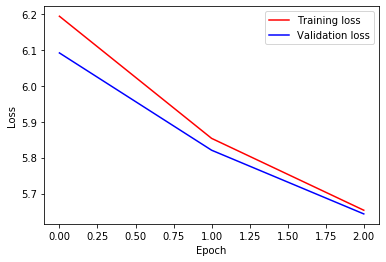

Time: 1m 15s Epoch: 4/60

Training loss: 5.509488582611084 	 Validation loss: 5.526791095733643 	 Perplexity: 251.33610213555852
donald trump N N years <unk> and a few years of the company is a $ N billion or <unk> to a major <unk> <unk> and the u.s. <unk> <unk> <unk> in a few months and that they have n't <unk> to be the first <unk> in the past market <unk> <unk> <unk> a N <unk> of the N million years in the u.s. <unk> the company said it has n't a new market <unk> in an own market <unk> to N million of $ cents a N million shares of $ million in $ to a $ yield in a N million


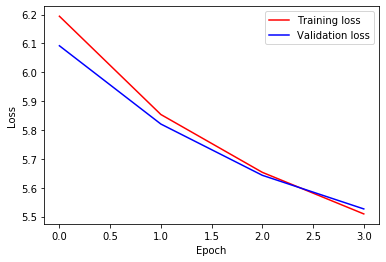

Time: 1m 34s Epoch: 5/60

Training loss: 5.39592170715332 	 Validation loss: 5.447030544281006 	 Perplexity: 232.06802601780495
donald trump <unk> of $ 300-a-share <unk> of the u.s. the new board <unk> the <unk> was a new <unk> in a <unk> in N to N <unk> a few months of <unk> and N N <unk> in an N years ago the u.s. and the N time <unk> to a N million <unk> <unk> in the N N of N N <unk> the N <unk> of N N of <unk> the N and the company was the company and N <unk> of its $ 300-a-share <unk> and N <unk> and the company is <unk> the first N <unk> of the <unk> in


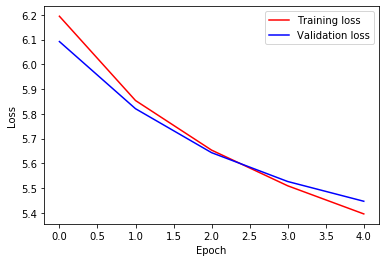

Time: 1m 53s Epoch: 6/60

Training loss: 5.297430992126465 	 Validation loss: 5.384402751922607 	 Perplexity: 217.9798771598997
donald trump N billion N billion rate rate rose N N in september N N N in the third year 's <unk> index was quoted N to yield N from the N months a share on a $ yield to N yen the N <unk> and <unk> and N N was quoted by N cents the first period the year of $ $ a $ $ 300-a-share $ $ a share in the u.s. the u.s. <unk> the market has a $ <unk> loss on its N million million shares of the <unk> <unk> <unk> in <unk> 's N billion N billion yen


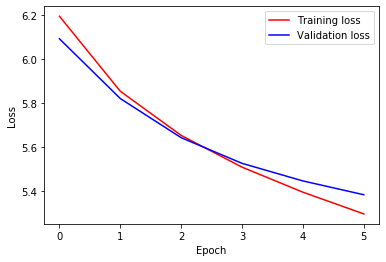

Time: 2m 12s Epoch: 7/60

Training loss: 5.219531059265137 	 Validation loss: 5.338540077209473 	 Perplexity: 208.2085199324764
donald trump the new york stock trading index of N the company was priced for the third months of a share of N N and $ N billion from N yen from its $ 300-a-share <unk> $ N billion of the <unk> market and a <unk> of N <unk> the <unk> is a N stake of $ $ million to a $ $ million the market the company said its $ half of N million in september the year was $ N million a week in its <unk> and $ five million or N N in its shares the average loss in N


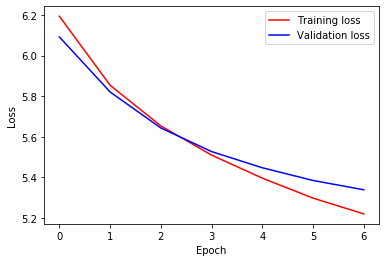

Time: 2m 31s Epoch: 8/60

Training loss: 5.149174690246582 	 Validation loss: 5.285898208618164 	 Perplexity: 197.53152831098
donald trump the N N N <unk> <unk> and the new company was n't sold in new <unk> to be used to the market and that <unk> is a result of the new york <unk> <unk> of its N N and a new firm for example <unk> the <unk> of <unk> in the <unk> and other <unk> of its new york <unk> <unk> the u.s. and the new jersey is <unk> the u.s. in new york the u.s. <unk> <unk> <unk> <unk> the <unk> and it has a good way in a lot for his own <unk> and a new jersey to be


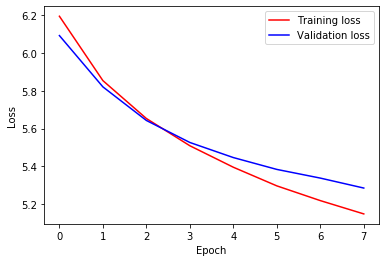

Time: 2m 50s Epoch: 9/60

Training loss: 5.089097023010254 	 Validation loss: 5.2453155517578125 	 Perplexity: 189.6756582746169
donald trump and N million of <unk> shares the <unk> of N <unk> was quoted N points by an estimated N N of a N N N rate at $ 300-a-share <unk> by <unk> 's N <unk> of the u.s. and the company 's <unk> of <unk> <unk> by an <unk> N million <unk> and a $ five billion increase for $ N a month earlier the company 's $ N a $ 300-a-share bid $ five yen $ half the <unk> company said a year of $ N billion the company 's <unk> and a <unk> <unk> in <unk> and the company


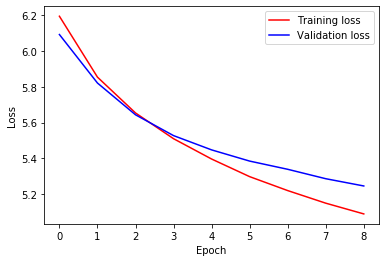

Time: 3m 9s Epoch: 10/60

Training loss: 5.033907413482666 	 Validation loss: 5.217870235443115 	 Perplexity: 184.54073692370724
donald trump and a result the company is the N <unk> and <unk> of a $ <unk> <unk> to <unk> and a N increase in its <unk> the u.s. which was a new <unk> and the government <unk> by a major company for $ three million <unk> and the first nine years in a N N increase from <unk> and a year for a N N rise for $ half $ 300-a-share share from a year and <unk> <unk> of a <unk> <unk> <unk> and an estimated $ five years in <unk> to a major <unk> and N billion $ five weeks in


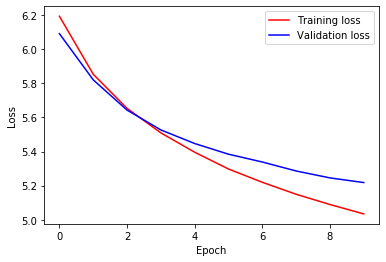

Time: 3m 28s Epoch: 11/60

Training loss: 4.986393928527832 	 Validation loss: 5.186448097229004 	 Perplexity: 178.83222883102493
donald trump and the N million <unk> of the company <unk> a new york stock exchange exchange of the company the new stock is a new bid of $ five years and a company <unk> <unk> said he has the company in a N to <unk> the first $ five weeks in <unk> trading at $ # a N billion <unk> <unk> in <unk> to N years old was <unk> up for $ three months in N the company was n't <unk> for $ five million in <unk> the first quarter the company has a <unk> of its <unk> operations the u.s. <unk>


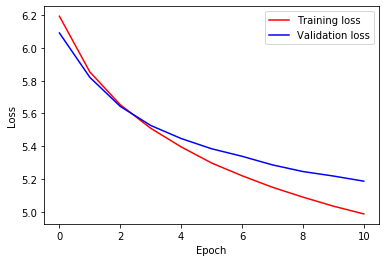

Time: 3m 47s Epoch: 12/60

Training loss: 4.944915294647217 	 Validation loss: 5.165407180786133 	 Perplexity: 175.10874497402332
donald trump and it <unk> in the first half in the past year to a <unk> in the first period from $ half in a week earlier in september N N the company is a $ $ N billion of $ N <unk> contract in new jersey to <unk> its N million N million francs from a <unk> N stake and N <unk> of <unk> 's largest company <unk> and N <unk> the u.s. and exchange of N shares the first nine million months ended from sept. half of a $ 300-a-share $ # a share in N and the N period was


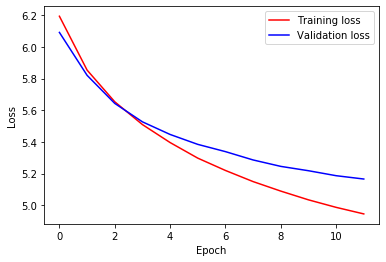

Time: 4m 6s Epoch: 13/60

Training loss: 4.910292625427246 	 Validation loss: 5.145268440246582 	 Perplexity: 171.61754754500174
donald trump the u.s. government market <unk> <unk> of a <unk> in a major new jersey <unk> and that the market is expected the market 's stock is <unk> in N but they were the N billion yen $ five years in N years of N years old said the <unk> was a $ <unk> to <unk> and a <unk> in a number that was the most important days in the past week that the government was <unk> by N <unk> a day and a <unk> <unk> in <unk> <unk> in <unk> <unk> <unk> and <unk> and the N N of its new


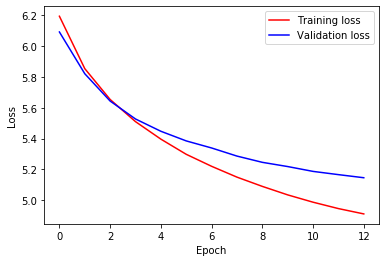

Time: 4m 25s Epoch: 14/60

Training loss: 4.876996994018555 	 Validation loss: 5.117127418518066 	 Perplexity: 166.8553748791269
donald trump is a new bid in <unk> and other <unk> <unk> in new england <unk> and the N million N N of its own share for N <unk> in new england <unk> N <unk> and the new <unk> the u.s. <unk> <unk> <unk> the N years <unk> the company is the N N <unk> and N of the N <unk> in <unk> the u.s. market as well <unk> by an <unk> and to <unk> the government in the <unk> of <unk> a N 1\/2-year stake on the N million years the u.s. <unk> and the N <unk> N million N in <unk>


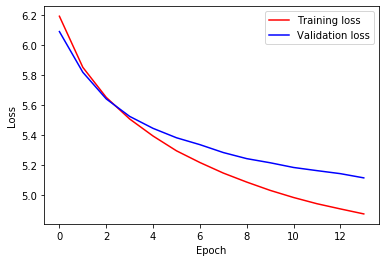

Time: 4m 44s Epoch: 15/60

Training loss: 4.847219467163086 	 Validation loss: 5.093575477600098 	 Perplexity: 162.97152260521696
donald trump <unk> the new jersey <unk> <unk> of the u.s. and the new <unk> the u.s. was in the N years in new england <unk> the <unk> to <unk> <unk> the u.s. and other <unk> of a series <unk> of their work on its new york <unk> the new union has become a $ N million charge for each of N and $ N in N the government was <unk> in a $ $ billion in $ 300-a-share a share in new zealand stock to a N billion yen in the past N weeks of a <unk> in the <unk> market the


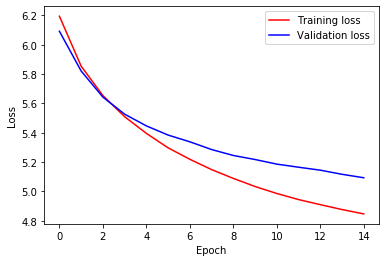

Time: 5m 3s Epoch: 16/60

Training loss: 4.816458702087402 	 Validation loss: 5.073360443115234 	 Perplexity: 159.7101233675606
donald trump <unk> <unk> of the new york-based stock markets in the u.s. <unk> of <unk> in new england the new <unk> is n't in <unk> in N in a <unk> and the market is the <unk> to <unk> in an hour in recent <unk> <unk> in a <unk> <unk> and <unk> the <unk> the most important <unk> and that it 's no to get the best for example it was a lot of a lot that can do a good <unk> for their own and <unk> and the most people do to have <unk> the N N N years in an hour


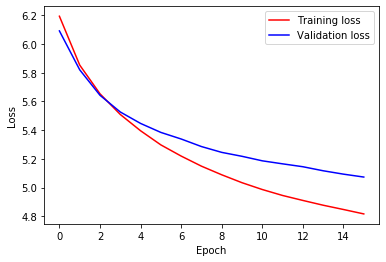

Time: 5m 22s Epoch: 17/60

Training loss: 4.788774013519287 	 Validation loss: 5.058358192443848 	 Perplexity: 157.33199530184353
donald trump is an <unk> of a series at a N million swiss rate of the treasury bonds were priced for N to yield at N yen a week earlier the average price index fell to $ N and <unk> N points in october and at least $ N in the market was N N the treasury was a <unk> of N billion francs of N million shares outstanding the dow said that N points of N and the N <unk> of N shares the index N points to be the N billion shares on oct. five N the dollar has N million


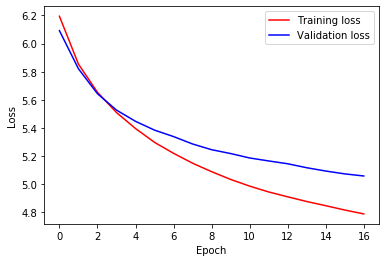

Time: 5m 41s Epoch: 18/60

Training loss: 4.765761375427246 	 Validation loss: 5.041606903076172 	 Perplexity: 154.7184329064864
donald trump and a <unk> of this month a <unk> of N shares at the <unk> market <unk> a <unk> N <unk> <unk> in the new zealand and a day for a new market <unk> to <unk> <unk> in N and N <unk> a year of new hampshire and N <unk> the u.s. which was $ <unk> for the first N <unk> N of a <unk> <unk> N N and <unk> in a <unk> N years the company said the <unk> was n't the first time of the u.s. to make its N N of a year and a year ago to the


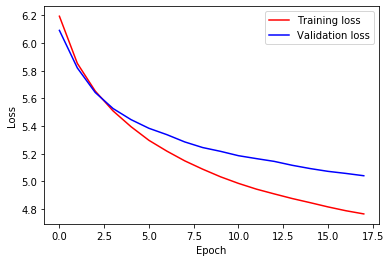

Time: 6m 0s Epoch: 19/60

Training loss: 4.739564895629883 	 Validation loss: 5.023806571960449 	 Perplexity: 151.9887601849453
donald trump <unk> in a statement <unk> <unk> the firm 's <unk> is <unk> the new <unk> in an effort in N and <unk> to <unk> the new york city 's first N years ago the new jersey has <unk> a new line in <unk> the company <unk> and the company to be used as <unk> as a few years ago <unk> in a N N stake <unk> and N <unk> in an estimated $ <unk> <unk> of N to $ N and $ $ a share the <unk> is <unk> the N N N in <unk> a new <unk> and the u.s.


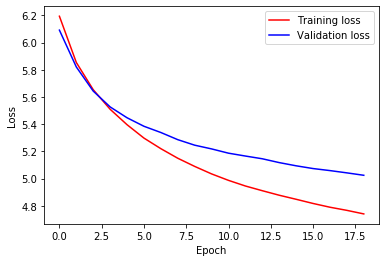

Time: 6m 19s Epoch: 20/60

Training loss: 4.72067928314209 	 Validation loss: 5.008835792541504 	 Perplexity: 149.73031748661225
donald trump the company said it had been a good bid of the <unk> and a <unk> for its first nine years the u.s. company will have a N billion <unk> <unk> of <unk> in a <unk> period in a <unk> period that has been <unk> to an estimated about # $ million a <unk> period the u.s. said it is n't expected in <unk> to be completed as much by a new york <unk> of new <unk> in N and its first time in the u.s. <unk> N N the government in N the government said its N largest annual revenue of


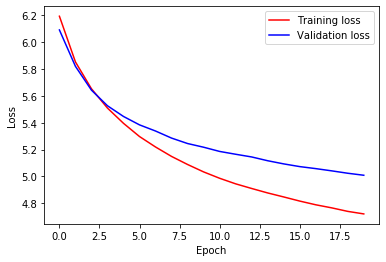

Time: 6m 38s Epoch: 21/60

Training loss: 4.71088981628418 	 Validation loss: 5.005047798156738 	 Perplexity: 149.16421276241692
donald trump <unk> of a N basis of <unk> and N shares in a statement the <unk> said the dollar 's N <unk> is <unk> the dollar is the market at N cents up from the N billion yen in the N stock market and <unk> prices closed on oct. $ five million in the first nine of this market and a day to the dollar on oct. the <unk> the market was <unk> the dow industrials fell N in a N N rise to N yen N N the average N points in a day in N and N the treasury was


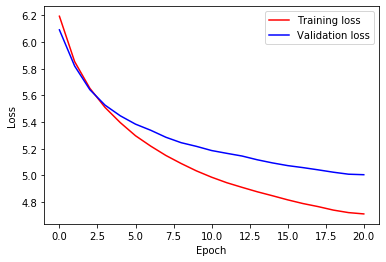

Time: 6m 57s Epoch: 22/60

Training loss: 4.701005458831787 	 Validation loss: 5.018139839172363 	 Perplexity: 151.1299162120904
donald trump 's a good of a N basis to $ to $ five a year or a share for a year 's <unk> and N N from the <unk> and N N and the total rate for a total rate to N million N the year in the latest year ended sept. # # # N billion in september N and from $ $ $ billion the previous period was quoted at N yen from the $ five years a month the bank is n't a <unk> in addition the stock is expected for comment a year of stock in the stock


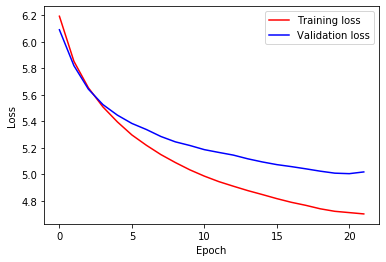

Time: 7m 16s Epoch: 23/60

Training loss: 4.6824822425842285 	 Validation loss: 5.011660575866699 	 Perplexity: 150.15387113272106
donald trump <unk> in <unk> of new zealand 's new stock index of <unk> issues closed by a <unk> of N shares on tuesday at <unk> the dollar 's index fell about N points points to close the market 's <unk> <unk> and that <unk> <unk> <unk> <unk> in N the <unk> <unk> <unk> and the N crash <unk> in a new jersey market for example the <unk> and <unk> were on <unk> <unk> by N to N and <unk> the <unk> of their N N stocks to the u.s. the dollar is a big <unk> and market <unk> to a market and


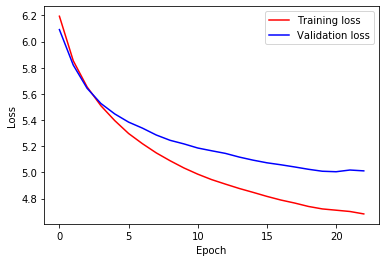

Time: 7m 35s Epoch: 24/60

Training loss: 4.668527126312256 	 Validation loss: 5.0002923011779785 	 Perplexity: 148.45654678463617
donald trump 's and a N stake to N point to N shares in september from september in N the <unk> <unk> <unk> said in september the market 's <unk> <unk> in <unk> the dollar has a big loss of <unk> from N in october and the average of N stocks and <unk> the N <unk> of its stock exchange composite in tokyo stocks the nikkei of N shares was quoted down N at $ cents a pound down from the first time and was N yen in september in october the dollar fell N cents to the dow 's average price volume


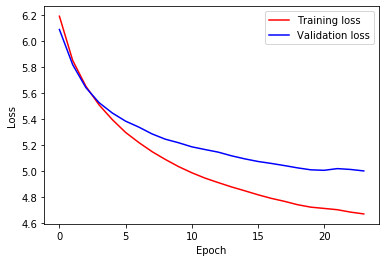

Time: 7m 54s Epoch: 25/60

Training loss: 4.64880895614624 	 Validation loss: 4.995621681213379 	 Perplexity: 147.76477942213256
donald trump <unk> <unk> <unk> a new jersey manager for <unk> & poor co. of <unk> <unk> inc. and a new york-based <unk> company that will sell their shares the company has been <unk> in an effort to buy the company 's shares outstanding as of its first quarter ended march the company had net profit at about a loss to be down in a year and in a <unk> price stock prices rose the dow closed at $ N the stock closed up $ $ to a <unk> $ N million bid that the company said a $ 300-a-share loss of $


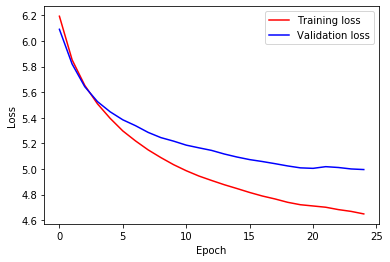

Time: 8m 13s Epoch: 26/60

Training loss: 4.627073764801025 	 Validation loss: 4.977659702301025 	 Perplexity: 145.1343263634795
donald trump 's a <unk> N to N cents to be <unk> and in N the stock exchange index N N to N and N the <unk> index gained N N the dollar is the <unk> of the stock index of the stock market as <unk> the dollar was quoted on friday in september trading at N marks the company said the company has <unk> the stock market and to make <unk> stocks the dow <unk> N <unk> N in the first half this summer the nasdaq futures was n't in <unk> trading at a lower price on oct. about a week of


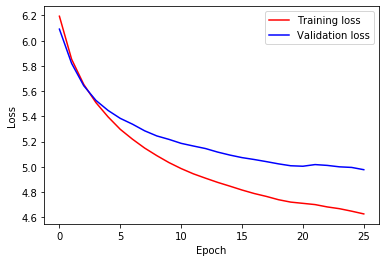

Time: 8m 32s Epoch: 27/60

Training loss: 4.611498832702637 	 Validation loss: 4.964897632598877 	 Perplexity: 143.29388090033933
donald trump <unk> <unk> a <unk> of a N to the company in <unk> of a company <unk> and the <unk> of its new york-based company the first N months was N and N <unk> <unk> the N million <unk> <unk> <unk> N million old of the <unk> of N <unk> N and the u.s. <unk> <unk> the company <unk> its own a new york stock to the <unk> of a series of N and <unk> in N with <unk> and the <unk> and <unk> by the <unk> <unk> and the world <unk> <unk> of its first half of a year 's total


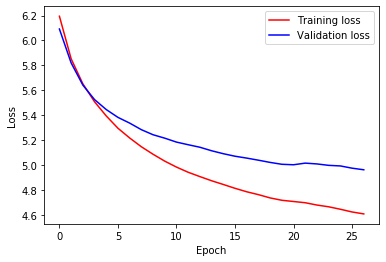

Time: 8m 51s Epoch: 28/60

Training loss: 4.598260402679443 	 Validation loss: 4.9639787673950195 	 Perplexity: 143.1622736131925
donald trump has N N other share it is a very part for a lot to <unk> and the industry is the same <unk> of its <unk> in a new business the industry says a new york <unk> company <unk> <unk> a new <unk> <unk> to an analyst for <unk> <unk> & poor a <unk> of the <unk> group <unk> a new firm <unk> in a series with a number to buy N <unk> in the past few days <unk> 's biggest <unk> and other people were <unk> to <unk> their business and <unk> <unk> and other other companies <unk> to a new


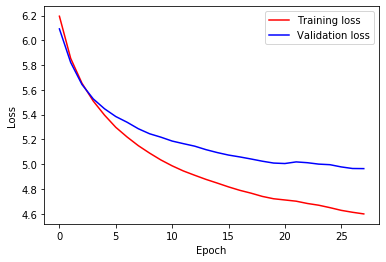

Time: 9m 10s Epoch: 29/60

Training loss: 4.589452743530273 	 Validation loss: 4.971505165100098 	 Perplexity: 144.24383484519115
donald trump and it 's a little for <unk> <unk> and <unk> in N to a <unk> of N N N the <unk> of the u.s. <unk> and a N increase in the <unk> N years of <unk> will <unk> <unk> by N years ago the u.s. government rate to be <unk> to a new york area the government has n't seen <unk> and the <unk> and a lot that will <unk> in a few weeks <unk> 's recent years and <unk> <unk> in an <unk> in an attempt the u.s. court of the soviet party has n't yet seen a major government


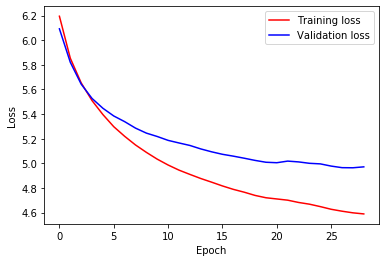

Time: 9m 29s Epoch: 30/60

Training loss: 4.570898532867432 	 Validation loss: 4.960927486419678 	 Perplexity: 142.72611105698573
donald trump the <unk> the issue 's <unk> <unk> and <unk> of a <unk> in N when he was a little in a series of N and <unk> to <unk> in <unk> and N N <unk> in his N N years the <unk> has a lot of more and N <unk> in a N years the company is n't the best to take in the <unk> market he says <unk> the president for a <unk> in the company that the u.s. has a lot to increase their own in N he says <unk> the <unk> <unk> in an interview that <unk> <unk> in


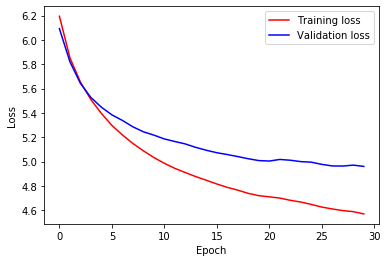

Time: 9m 47s Epoch: 31/60

Training loss: 4.552990913391113 	 Validation loss: 4.947668075561523 	 Perplexity: 140.84613812047735
donald trump <unk> <unk> and <unk> in a few <unk> with the world and the most active market the dollar was <unk> by a N drop to $ five a <unk> from <unk> and <unk> <unk> the dollar <unk> in N in the u.s. and <unk> in N in september the dollar rose N points to N marks and the <unk> N <unk> <unk> the dollar is the biggest active <unk> market <unk> stocks <unk> in london the <unk> <unk> was a <unk> in N <unk> and the dollar <unk> <unk> up N to N the average volume is in N and at


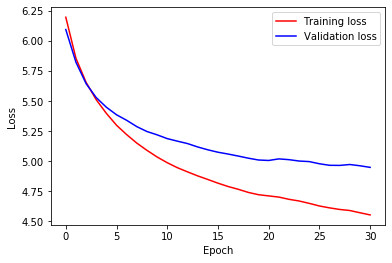

Time: 10m 6s Epoch: 32/60

Training loss: 4.535507678985596 	 Validation loss: 4.944410800933838 	 Perplexity: 140.38810993513047
donald trump has the <unk> <unk> the first time in <unk> <unk> <unk> the new <unk> is that it is <unk> in a series of <unk> <unk> with an average at least time <unk> 's work is a <unk> to the <unk> <unk> and other people <unk> <unk> <unk> to a <unk> the problem <unk> the world <unk> a series N <unk> in an <unk> of N years of N <unk> and <unk> in a N area the first N <unk> N pages $ about $ five and <unk> <unk> in a <unk> and a series at N p.m. edt the <unk> was


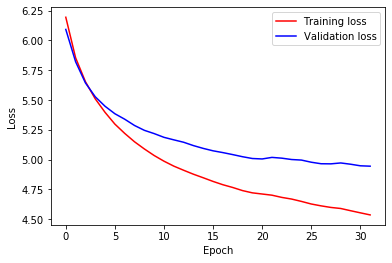

Time: 10m 25s Epoch: 33/60

Training loss: 4.528107643127441 	 Validation loss: 4.936942100524902 	 Perplexity: 139.34349899993236
donald trump <unk> <unk> of an estimated <unk> of the $ $ million a $ to $ N billion or N years of revenue and a N million rate in a year ago he says <unk> <unk> said it will <unk> the first quarter of the company and to be <unk> to a $ $ N billion bid in N the u.s. and exchange of N billion in a <unk> of the <unk> system is <unk> to <unk> by a new company for the <unk> and a <unk> in <unk> <unk> <unk> said the company 's <unk> was made for a $ N


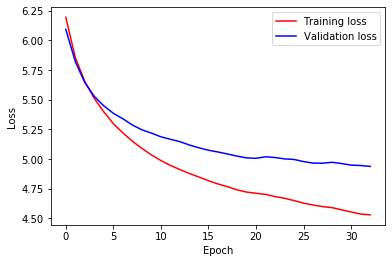

Time: 10m 44s Epoch: 34/60

Training loss: 4.5175957679748535 	 Validation loss: 4.932162284851074 	 Perplexity: 138.67905199151028
donald trump 's in a <unk> of the first <unk> of the <unk> to be used in this year but a year in the latest quarter a spokesman in new orleans <unk> is expected for comment a new york-based spokesman also said in its first time it has been expected and that its first quarter were n't expected in august N the <unk> company reported third-quarter third-quarter sales of about $ billion yen the year 's sales fell N million from N yen the previous period of the first year the year earlier this quarter said it will be expected for a year


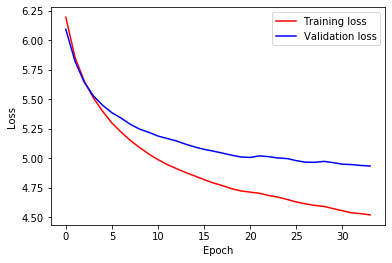

Time: 11m 3s Epoch: 35/60

Training loss: 4.50111722946167 	 Validation loss: 4.9345808029174805 	 Perplexity: 139.01485569416192
donald trump has the only N years <unk> to N years in addition to the company 's earnings profit for the quarter the <unk> was $ $ a year a year ago for <unk> and other analysts say the industry 's latest quarter included profit of N cents an ounce in the quarter was $ about an increase from $ $ million or a <unk> N cents an ounce the first year was a loss from N cents for a year 's share the <unk> segment said the results are <unk> the <unk> <unk> of a <unk> to <unk> and a <unk> in


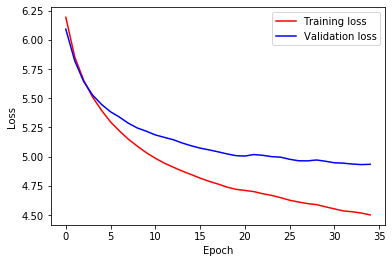

Time: 11m 22s Epoch: 36/60

Training loss: 4.486620903015137 	 Validation loss: 4.932706356048584 	 Perplexity: 138.75452379855332
donald trump has N <unk> the N largest <unk> of <unk> <unk> the first <unk> of this month is n't likely the <unk> of N billion N yen N cents an <unk> <unk> <unk> said the company 's earnings decline to rise on a <unk> N billion sales in september N a year in august N in a N decline the u.s. said net for its fiscal third of a quarter ended the year was up from # N billion for $ $ $ $ billion an average of the year 's $ <unk> and a N N rise for <unk> <unk> the


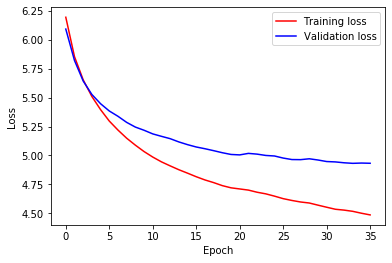

Time: 11m 41s Epoch: 37/60

Training loss: 4.472135066986084 	 Validation loss: 4.928627014160156 	 Perplexity: 138.18964959824703
donald trump and the N issue of its <unk> and N <unk> in <unk> <unk> and a new line for each N <unk> of a $ million <unk> in a series <unk> of the u.s. 's N <unk> of its own plant which <unk> <unk> in its N <unk> the first <unk> in <unk> and its <unk> to a new company of N miles <unk> in its own line with a N million <unk> and a year ago the N N total sales of the first year the <unk> <unk> was a year in august and a year to $ about N a


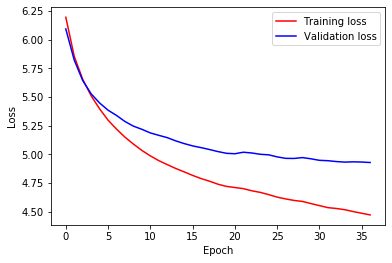

Time: 12m 0s Epoch: 38/60

Training loss: 4.454794883728027 	 Validation loss: 4.926746845245361 	 Perplexity: 137.93007381435342
donald trump is a first N N N to be a year at N a.m. edt at a end in the u.s. and market in recent weeks but the average decline of about three days as much of a N million average of the N million in the third period in september in the latest period in august N in august and <unk> in the past half of august and N marks in N in october from N in N and in august in october N N N the u.s. and the <unk> of economic economic figures have said <unk> <unk> of the


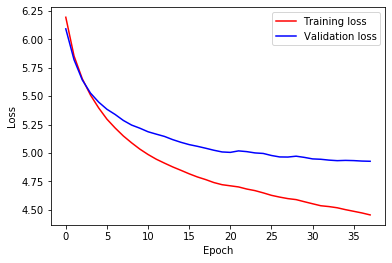

Time: 12m 19s Epoch: 39/60

Training loss: 4.446201801300049 	 Validation loss: 4.9266462326049805 	 Perplexity: 137.91619700354204
donald trump and in N N in a statement <unk> <unk> inc. of new england and a unit with international <unk> corp the bank will <unk> <unk> <unk> in new york and a N billion <unk> in new england court and <unk> in N in the past week to <unk> <unk> the new u.s. government administration officials also had to make the <unk> in <unk> and to have the u.s. to the N N years <unk> and <unk> in an area with <unk> and the state in new england <unk> of N years ago the <unk> <unk> of the country and the most


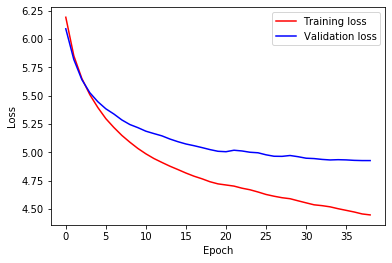

Time: 12m 38s Epoch: 40/60

Training loss: 4.438956260681152 	 Validation loss: 4.930145740509033 	 Perplexity: 138.39968131021115
donald trump 's a <unk> <unk> in an attempt by N N the government has N years of dollars N N from <unk> 's total $ $ million the <unk> is <unk> of the $ 300-a-share offer of $ <unk> $ 300-a-share $ of the $ N a series is the first of an estimated that <unk> for $ six years and to $ N for $ $ N a month the new <unk> is $ <unk> <unk> of the <unk> 's N N and a series that is <unk> in <unk> and the N N N N are due in a series


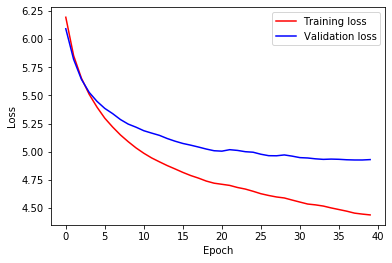

Time: 12m 57s Epoch: 41/60

Training loss: 4.4315080642700195 	 Validation loss: 4.926820278167725 	 Perplexity: 137.94020279465116
donald trump is a <unk> the <unk> to make <unk> on <unk> and other <unk> and the company is a lot in that area with N <unk> <unk> and a few of them who <unk> to the same day the <unk> in <unk> <unk> a N pages N N and N in a <unk> of its N <unk> N and the company said <unk> in a <unk> period with N million yen in september and N million yen in the first nine weeks <unk> of the year earlier it will be expected in a third quarter of its $ <unk> <unk> in a


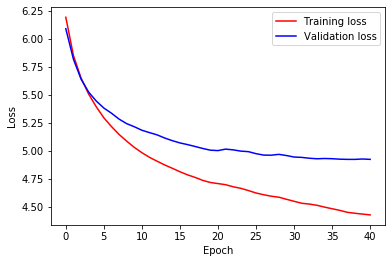

Time: 13m 16s Epoch: 42/60

Training loss: 4.421751022338867 	 Validation loss: 4.925358295440674 	 Perplexity: 137.73868394523177
donald trump <unk> & co a N N <unk> gain from its <unk> of its own <unk> <unk> <unk> N pages a <unk> <unk> and the company <unk> a series of common and the company said that it is <unk> a company with <unk> to <unk> and the <unk> and other other of its N other companies that <unk> are the first of a <unk> and in its own business but he said the company has n't disclosed it has to sell N N in its first nine weeks to <unk> N N of N from <unk> the u.s. which had n't expected


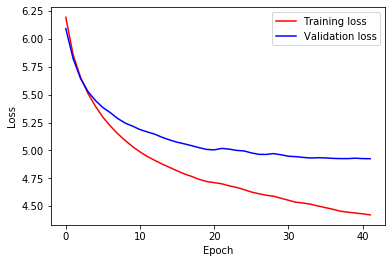

Time: 13m 35s Epoch: 43/60

Training loss: 4.415253639221191 	 Validation loss: 4.927177429199219 	 Perplexity: 137.98947707902076
donald trump co. <unk> the first N days of the <unk> to the first N <unk> of a year earlier this month said <unk> a former president <unk> <unk> in a N interview that 's not to take this week he 's not seen as well the <unk> he says mr. krenz 's <unk> <unk> was in a <unk> of <unk> <unk> in an hour in the <unk> of the past two days of the N N of the world <unk> <unk> the N of his own and the most successful <unk> in the N of the N N crash he said the


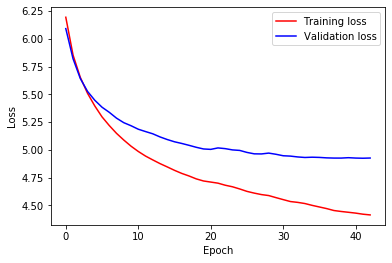

Time: 13m 54s Epoch: 44/60

Training loss: 4.400158405303955 	 Validation loss: 4.927187919616699 	 Perplexity: 137.99092465383603
donald trump 's and <unk> a lot N N points in the past five years of N N and N the company had <unk> up a total N of its total rate by about the end by a year the company also has said the latest year was the N decline in sales and in a year in august and its N decline the latest year was N down $ $ a ton to # $ $ five <unk> and a year of the <unk> <unk> said he said in an attempt in <unk> <unk> <unk> to <unk> the new <unk> in an


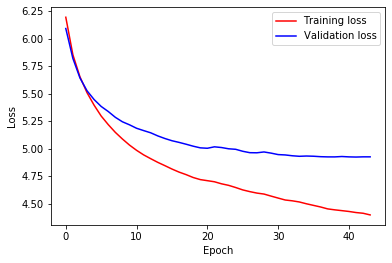

Time: 14m 13s Epoch: 45/60

Training loss: 4.3976569175720215 	 Validation loss: 4.9260993003845215 	 Perplexity: 137.84078681568818
donald trump 's a first N N in <unk> to N <unk> in new orleans the u.s. said that a N billion <unk> in the third of its first year and that <unk> is the same time in <unk> a N <unk> and a year of the year the company 's biggest trade <unk> has made a <unk> in an interview for example the u.s. <unk> has n't been made for the first to the u.s. and other other u.s. officials have been the first to the government 's decision on an average meeting at <unk> the government and other economic policy for


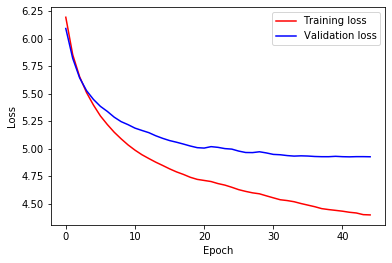

Time: 14m 32s Epoch: 46/60

Training loss: 4.390246391296387 	 Validation loss: 4.918745994567871 	 Perplexity: 136.83091884063802
donald trump the <unk> the new jersey 's first <unk> will take up to N years and <unk> the N million yen us$ N million of N <unk> and <unk> the u.s. 's largest industrial bank in the N crash said <unk> <unk> the company with an agreement to be <unk> in <unk> and to reduce <unk> costs for a <unk> period that <unk> in the u.s. market <unk> by west coast and other countries are expected a N increase in a <unk> period the first year to N yen the year in september and its total rate in october of september 's


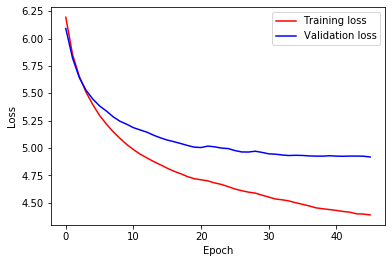

Time: 14m 50s Epoch: 47/60

Training loss: 4.377961158752441 	 Validation loss: 4.922743320465088 	 Perplexity: 137.3789712583612
donald trump 's <unk> and <unk> a <unk> of the <unk> of its <unk> in a new jersey business and <unk> <unk> in N to N years in the u.s. <unk> in a statement <unk> with an average of $ $ <unk> a day with <unk> <unk> in <unk> and a <unk> in the first N <unk> <unk> by the <unk> <unk> of <unk> <unk> the red <unk> was to N <unk> in N and then it <unk> a <unk> <unk> of his first to the world and i 've <unk> a N N stake and a <unk> <unk> in N and <unk>


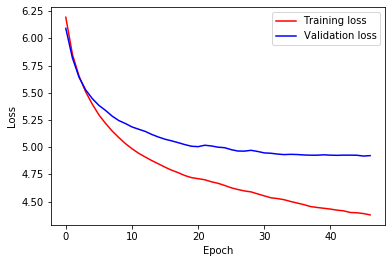

Time: 15m 9s Epoch: 48/60

Training loss: 4.365481853485107 	 Validation loss: 4.927727699279785 	 Perplexity: 138.06542945493382
donald trump is the N N issue is in the latest year of the company the average yield N points on monday N the dollar was unchanged by N N and N N on N shares on a <unk> issue at N marks up to a <unk> of N and <unk> <unk> the treasury N shares <unk> index rose N points at an average rate of the N shares ended oct. $ N in the third session as a day the dollar is <unk> in the first half to the N dollar index with the <unk> and other market issues the nasdaq composite


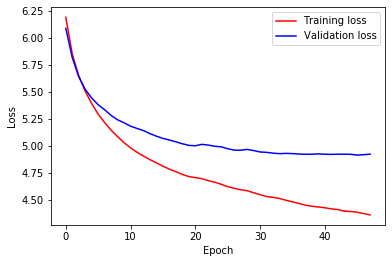

Time: 15m 28s Epoch: 49/60

Training loss: 4.3614349365234375 	 Validation loss: 4.931912422180176 	 Perplexity: 138.644405601782
donald trump the N N N <unk> in <unk> <unk> a new york-based firm of <unk> <unk> in a new zealand and <unk> of <unk> to <unk> the u.s. market as much as N as the first <unk> as <unk> in N when it was n't <unk> by <unk> and then <unk> <unk> the N million in <unk> the u.s. has N N <unk> and N <unk> from a few of the u.s. and N people are in <unk> in a few <unk> <unk> in N to the u.s. government <unk> a N years of the u.s. economy is n't <unk> for the


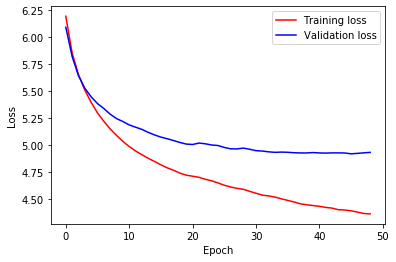

Time: 15m 47s Epoch: 50/60

Training loss: 4.352333068847656 	 Validation loss: 4.949533939361572 	 Perplexity: 141.10918315776465
donald trump co. <unk> <unk> <unk> N and a <unk> of N million ounces in the <unk> and the <unk> <unk> in which the u.s. was <unk> in N in a N range in N the company said he had a <unk> <unk> of <unk> and the N <unk> in N the N pages N and a month <unk> N in a week to be sold to a year at N a.m. to be a day at a time the company said it has n't <unk> a major trade deficit and to end the <unk> in august with the dollar in a <unk>


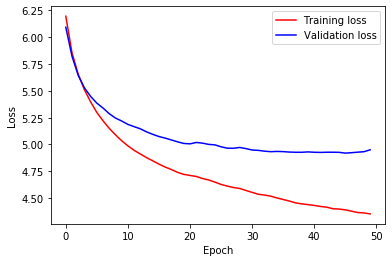

Time: 16m 6s Epoch: 51/60

Training loss: 4.341865539550781 	 Validation loss: 4.956257343292236 	 Perplexity: 142.06111371535425
donald trump <unk> who is n't the best to be a <unk> of <unk> <unk> the first of a series N <unk> <unk> <unk> in the past two months a week of <unk> <unk> and <unk> to be a major problem for <unk> in an interview that is the same as the first to show in an interview in an effort for the next year but a major <unk> of a number of the u.s. was <unk> the u.s. <unk> the <unk> in <unk> to a new <unk> and <unk> of the N crash in an area N to a <unk> in <unk>


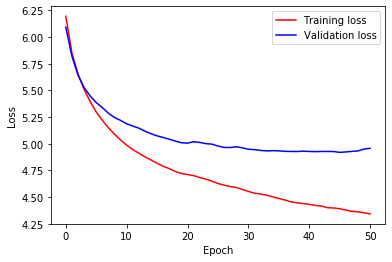

Time: 16m 25s Epoch: 52/60

Training loss: 4.326245307922363 	 Validation loss: 4.9624481201171875 	 Perplexity: 142.94331028935642
donald trump <unk> <unk> and <unk> in <unk> who <unk> the most successful <unk> on a series of N the company is n't the <unk> <unk> <unk> of <unk> the world is <unk> and <unk> the most successful computer in the first half a year with <unk> N N of <unk> N N in N N <unk> N and N <unk> <unk> the <unk> N <unk> in japan a N series N is the u.s. N series of N N N due nov. five N N at par via nomura bank bank ltd each fees $ $ N million in federal mortgage bank


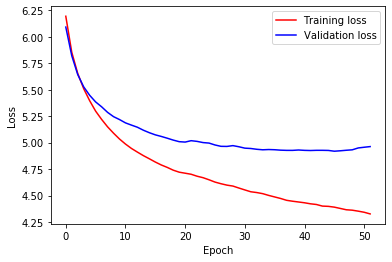

Time: 16m 44s Epoch: 53/60

Training loss: 4.318912029266357 	 Validation loss: 4.9745683670043945 	 Perplexity: 144.68636026109482
donald trump <unk> <unk> and <unk> in an <unk> in N <unk> said <unk> an economist by morgan bank in japan to report a N billion <unk> increase to N million yen $ N million from a year earlier this was n't available for an average <unk> of <unk> the company also said the u.s. <unk> <unk> in the past N <unk> will continue as a major <unk> the u.s. said it was <unk> by N <unk> the company said the N <unk> is <unk> the <unk> in N it 's <unk> <unk> and the most active in a N years that was


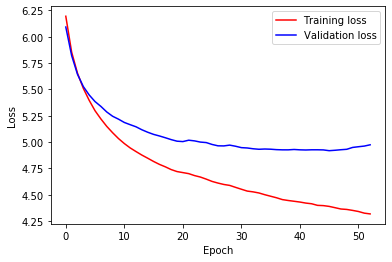

Time: 17m 3s Epoch: 54/60

Training loss: 4.306765079498291 	 Validation loss: 4.970343589782715 	 Perplexity: 144.07638204030087
donald trump the new york stock to N <unk> and sell at the N yen for <unk> the <unk> is in a series of N the market is a N billion increase in a year the average N rate for the year was quoted at $ about an N basis compared at the first quarter in august N N and $ about $ 300-a-share $ <unk> an ounce at $ $ N a year in the <unk> period in N to a new gain from $ about an hour of <unk> N N to N the company was <unk> a N million loss


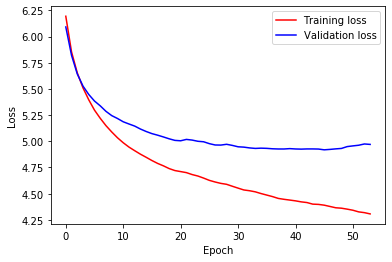

Time: 17m 22s Epoch: 55/60

Training loss: 4.302304267883301 	 Validation loss: 4.946744441986084 	 Perplexity: 140.71610795769442
donald trump <unk> 's the <unk> <unk> a <unk> in <unk> with the <unk> in the <unk> of an interview mr. jones said the company is n't likely for years of the N months it 's <unk> and that it was not to <unk> in <unk> and then i 'll have been a <unk> and that <unk> in N he <unk> a new <unk> at his time he has been a lot in this <unk> the first <unk> to be the first <unk> to <unk> in N he <unk> <unk> a former vice president for the company at <unk> corp. of new <unk>


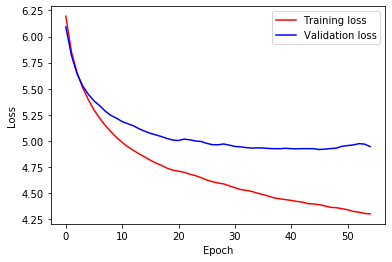

Time: 17m 41s Epoch: 56/60

Training loss: 4.293549537658691 	 Validation loss: 4.935667991638184 	 Perplexity: 139.16607326340596
donald trump 's the largest the issue 's a result of N million dollars us$ N to N the N <unk> issue which was N <unk> in april at an end of a <unk> N <unk> maker the first boston said in N that was n't the company 's biggest company 's <unk> <unk> said its net rose $ million in N million from $ N in an earlier fiscal fiscal quarter ended the third year the <unk> and a <unk> period of the year 's average and <unk> of $ $ billion for <unk> in the third period of $ five to


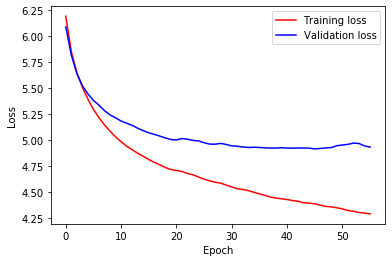

Time: 18m 0s Epoch: 57/60

Training loss: 4.282510280609131 	 Validation loss: 4.941204071044922 	 Perplexity: 139.9386442296679
donald trump the N <unk> to a N million stake in N in august and to N the N million in the <unk> company has a <unk> to the new line that would make a new <unk> of <unk> and other other companies the move said it expects its latest to report an increase for N million dollars of $ billion a <unk> from the company 's <unk> and <unk> business the <unk> will include an $ 300-a-share offer in a <unk> <unk> system the company said it is n't disclosed the transaction will have a <unk> loss of about N billion shares


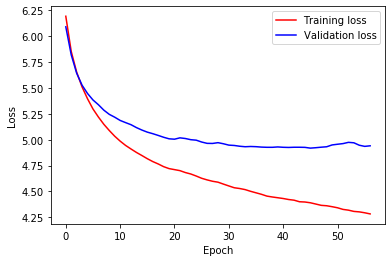

Time: 18m 19s Epoch: 58/60

Training loss: 4.277772426605225 	 Validation loss: 4.942476272583008 	 Perplexity: 140.11678768125404
donald trump co. the largest of its first boston to buy a <unk> <unk> for a <unk> that will produce <unk> N years ago to N years <unk> from the first N years the N <unk> of a series will be sold in april N in a new york exchange market is n't the biggest issue to an average N of its shares and by a series basis with a N N increase in N the <unk> <unk> issue was priced at N N in treasury bonds priced with an issue of a N N N yield from N N priced by <unk>


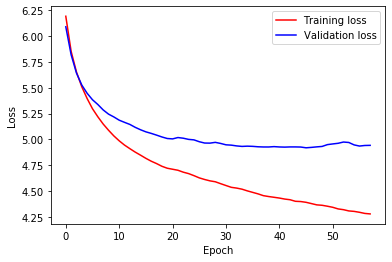

Time: 18m 38s Epoch: 59/60

Training loss: 4.26563024520874 	 Validation loss: 4.941470146179199 	 Perplexity: 139.97588337720777
donald trump <unk> the a <unk> <unk> and the a N <unk> <unk> <unk> by an international manager at <unk> <unk> inc. in a <unk> mass. <unk> <unk> in <unk> the new company the <unk> is <unk> <unk> <unk> a <unk> <unk> and <unk> in <unk> a computer maker in <unk> the <unk> has n't been the <unk> <unk> for N <unk> and N <unk> with their first year and N <unk> in <unk> with its first year to end a few weeks in recent weeks in a week to report a new york stock <unk> the <unk> of a new jersey series


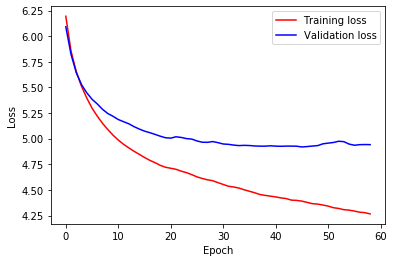

Time: 18m 57s Epoch: 60/60

Training loss: 4.256764888763428 	 Validation loss: 4.942521572113037 	 Perplexity: 140.12313504965053
donald trump & inc. and N N stake is n't a good price and is a good for <unk> said <unk> chief economist of a new firm in london and exchange <unk> <unk> the new firm is in <unk> with the u.s. the <unk> to make it <unk> a major way in the world market and the market has a little <unk> of a lot to make <unk> in fact mr. <unk> is that the company said <unk> is an <unk> <unk> to a $ 300-a-share bid in <unk> and then it 's an analyst who <unk> <unk> in the u.s. he 's


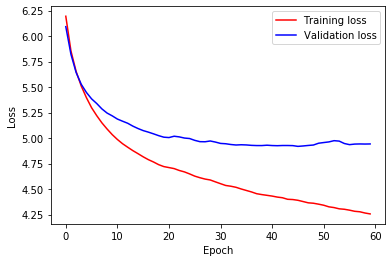

In [20]:
start = time.time()

for e in range(epochs):

    train_batches = get_batches(train_in_text, train_out_text, batch_size, seq_size)
    test_batches = get_batches(test_in_text, test_out_text, batch_size, seq_size)
    val_batches = get_batches(val_in_text, val_out_text, batch_size, seq_size)

    state_h, state_c = net.zero_state(batch_size)
    state_h = state_h.to(device)
    state_c = state_c.to(device)

    net.train()   #Training
    for x, y in train_batches:
    
        # Reset all gradients
        optimizer.zero_grad()

        x = torch.LongTensor(x).to(device)
        y = torch.LongTensor(y).to(device)

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        loss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        train_loss = loss.item()

        # Perform back-propagation
        loss.backward()

        # Update the network's parameters
        optimizer.step()

    training_loss.append(train_loss)

# Validation
    net.eval()
    
    state_h, state_c = net.zero_state(batch_size)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for x, y in val_batches:

        x = torch.LongTensor(x).to(device)
        y = torch.LongTensor(y).to(device)

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        val_losss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        val_loss = val_losss.item()
        
        perplexity = math.exp(val_loss)
        
    validation_loss.append(val_loss)
 
 # Test
    if e == epochs-1:
        state_h, state_c = net.zero_state(batch_size)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in test_batches:

            x = torch.LongTensor(x).to(device)
            y = torch.LongTensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            test_losss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            test_loss = test_losss.item()
            
        testing_loss.append(test_loss)

# Print    
    print('Time: {}'.format(time_since(start)),
          'Epoch: {}/{}\n'.format(e+1, epochs))
    print('Training loss: {}'.format(train_loss),
          '\t Validation loss: {}'.format(val_loss),
          '\t Perplexity: {}'.format(perplexity))
          #'\t Test loss: {}'.format(test_loss))
    
    initial_words=['donald', 'trump']
    predict(device, net, initial_words, n_vocab, vocab_to_int, int_to_vocab, top_k)

    epoch = np.arange(len(training_loss))
    plt.figure()
    plt.plot(epoch, training_loss, 'r', label='Training loss',)
    plt.plot(epoch, validation_loss, 'b', label='Validation loss')
    #plt.plot(epoch, testing_loss, 'g', label='Test loss')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('Loss')
    plt.show()

In [23]:
print("Epoch:", validation_loss.index(min(validation_loss))+1)
print("Validation loss:", min(validation_loss))
print("Perplexity:", math.exp(min(validation_loss)))
print("Training loss:", training_loss[validation_loss.index(min(validation_loss))])


Epoch: 46
Validation loss: 4.918745994567871
Perplexity: 136.83091884063802
Training loss: 4.390246391296387
